This notebook implements regression on the first round results with cross validation.

## Pipeline

- Data pre-processing: run codes/data_generating.py
- Reading data: read data/firstRound_4h.csv into pandas dataframe
- Cross validation: training (training, validating); testing, KFold (K = ?)
    - Emdedding
        - Onehot
        - Label 
    - Kernel
        - RBF
        - DotProduct
        - Spectrum 
            - lmer: l = ?
            - Padding_flag: add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ'
            - gap_flag:add gapped features, e.g. 3-mer-1-gap
            - normalised_kernel: e.g. zero-mean, unit-norm, unit-var
        - Sum of Spectrum
            - a K_A + b K_B + c K_C, where a + b + c = 1
    - Regression model
        - Gaussian process regression 
            - alpha: scalar value add to diagonal 
            - heteroscedastic: noises are learned as well (same as normalise each replicates to have same derivatives)
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

## Splitting in terms of sequences vs samples?

For each sequence, we have at least three biological replicates. There are two ways splitting data into training and testing data: splitting in terms of sequences, where if one sequence is split into the training dataset, then all replicates of that sequences belong to the training dataset; splitting in terms of samples, where the replicates of one sequence can be in the training or testing dataset. The two methods both make sense in terms of the evaluation of Gaussian process regression.

Considering the goal is to design good sequences for the second round experiment, we expect for training, we do not have any information about the sequences in the testing dataset. That is, splitting in terms of sequences can better simulate the sequence design task. 

In this notebook, we show both two methods of splitting data. We expect that splitting in terms of samples provide a lower error in testing data since the model may have seen the sequences. The test error of splitting sequences should have higher variance, since the prediction depends on whether the sequences in test dataset similar to the sequences in the training dataset. But again, our goal is to decrease the test error as well as the variance for the case of splitting sequences. 

## Evaluate on samples vs sample mean?

For training, we use the samples as labels, since we model the label for each sequence as samples from a unknown (Gaussian) reward distribution.

For testing, we use the sample mean for the sequence (i.e. mean value of the three replicates) as label. The ideal label should be the true mean of underlying distribution (we assume is Gaussian) of a sequence, however, we do not know the true mean. The only choice is to use the sample mean to approximate the true mean, which has the risk the sample mean would deviate a lot from the true mean since the number of samples is quite low (and variance of samples is not low). 

## Choices to make within cross validation 

- alpha: scalar value add to diagonal 
- kernel
- lmer: l = ?
- For Sum_Spectrum_Kernel: b for (1 - b)/2 K_A + b K_B + (1-b)/2 K_C

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel
    
}

In [3]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel_list = [#'Spectrum_Kernel', 
               #'Sum_Spectrum_Kernel', 
               'WD_Kernel']
alpha_list = [0.1, 1, 2, 3]
l_lists = [[3], [6]]
b_list = [0.33, 0.6, 0.8]

weight_flag = False
padding_flag = False
gap_flag = False

## Cross Validation for sequences

In [4]:
Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA
1,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps_core,CGGAGA
2,22,TTTAAGAGGGAGATATACAT,RBS_1by1_23,-0.616473,-0.502488,0.414480,-0.234827,0.565197,0.043805,bps_core,GGGAGA
3,23,TTTAAGATGGAGATATACAT,RBS_1by1_24,1.249077,0.811791,-0.085595,0.658424,0.680425,0.228128,bps_core,TGGAGA
4,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps_core,ACGAGA
5,25,TTTAAGAAAGAGATATACAT,RBS_1by1_26,-0.137300,-0.361841,0.782388,0.094415,0.606287,0.185443,bps_core,AAGAGA
6,26,TTTAAGAATGAGATATACAT,RBS_1by1_27,-0.663860,-0.616878,0.002153,-0.426195,0.371703,0.062400,bps_core,ATGAGA
7,27,TTTAAGAAGCAGATATACAT,RBS_1by1_28,-0.482614,-0.686311,-0.107793,-0.425572,0.293447,0.172987,bps_core,AGCAGA
8,28,TTTAAGAAGAAGATATACAT,RBS_1by1_29,-1.399968,-0.990957,-0.270713,-0.887213,0.571731,0.431229,bps_core,AGAAGA
9,29,TTTAAGAAGTAGATATACAT,RBS_1by1_30,-0.823305,-1.716794,-0.850261,-1.130120,0.508253,0.723149,bps_core,AGTAGA


In [5]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(150, 11)

Train:  0.9024536477307465
Test:  0.2629597500205618


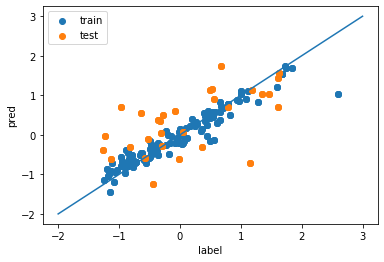

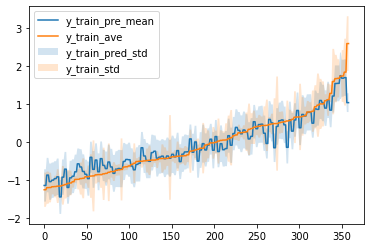

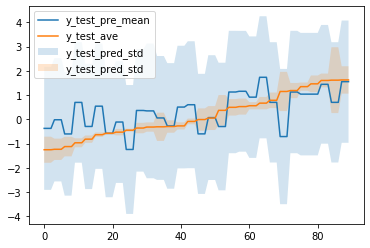

In [6]:
regression(df, random_state=24, test_size=0.2, kernel_name='WD_Kernel',alpha=0.8, embedding='label',
               eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
               weight_flag=False, padding_flag=False, gap_flag=False)

Train:  0.519314783258757
Test:  0.4263745806253534


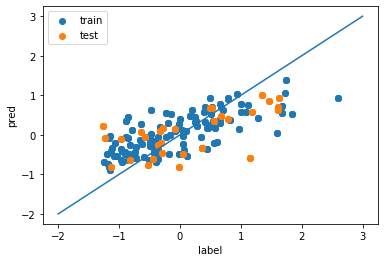

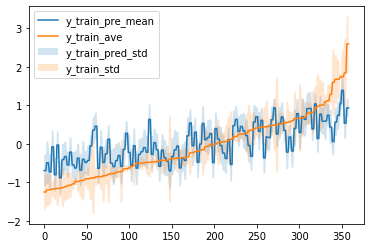

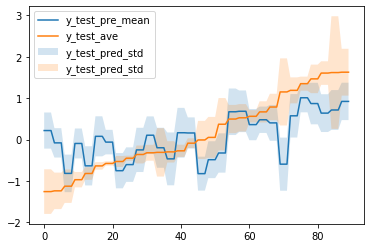

In [20]:
regression(df, random_state=24, test_size=0.2, kernel_name='Spectrum_Kernel',alpha=2, embedding='label',
               eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
               weight_flag=False, padding_flag=False, gap_flag=False)

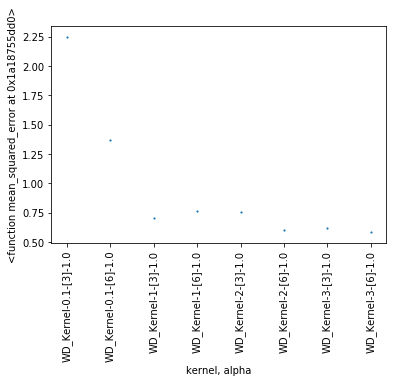

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.05504194791762823
Test:  0.5647770677316403


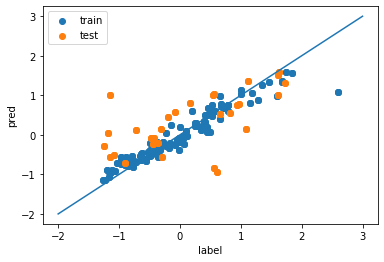

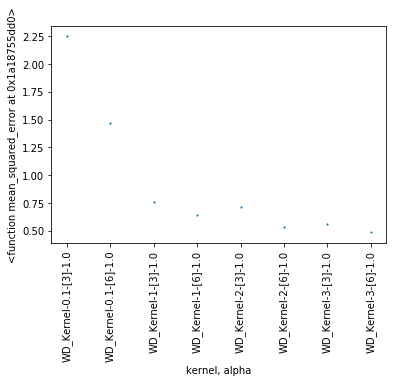

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.05139047562945898
Test:  0.5869383780335269


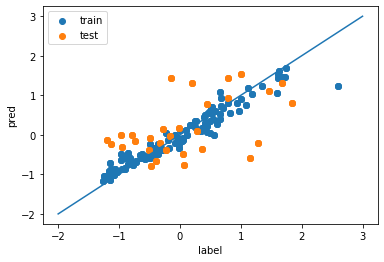

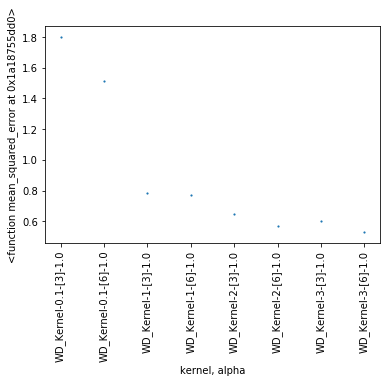

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.036867961790418444
Test:  0.6550356990343918


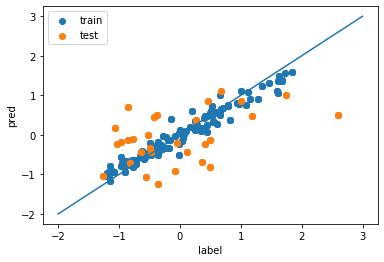

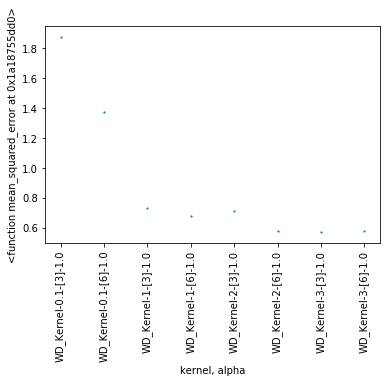

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [3] , optimal b:  1.0
WD_Kernel
1
Train:  0.11976382388610309
Test:  0.5932342988827545


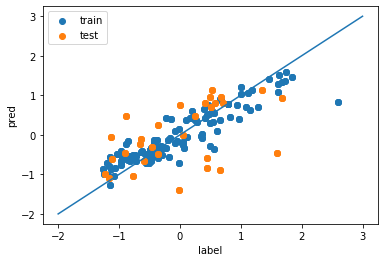

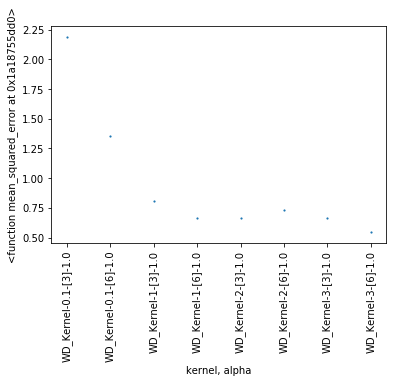

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.055124438063478984
Test:  0.48665670428111935


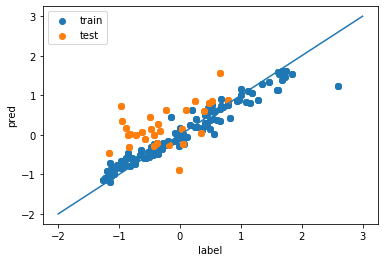

Cross-validation Test mean:  0.5773284295926866
Cross-validation Test std:  0.05433721738649734


In [7]:
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, kernel_list,  alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting sequences case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  2 , 
- optiaml l list:  [2, 3, 4, 5, 6]

## Cross Validation for samples

In [8]:
Path = '../../data/firstRound_4h+Baseline.csv'

df_samples = pd.read_csv(Path)
df_samples.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,reference,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


In [9]:
df_samples_frr = df_samples[df_samples['Group'] != 'Baseline data'].reindex()

In [10]:
df_samples_frr.shape

(449, 8)

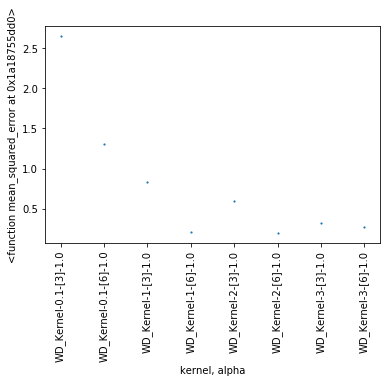

optimal kernel:  WD_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.055771911203647724
Test:  0.11008023970293969


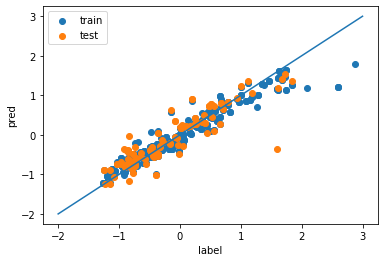

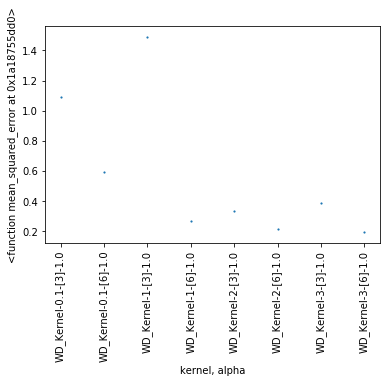

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.07907784681650934
Test:  0.233790833086488


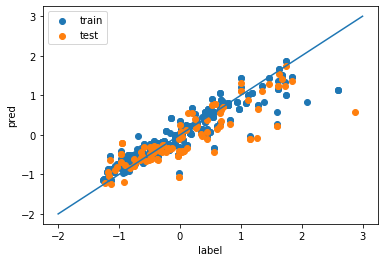

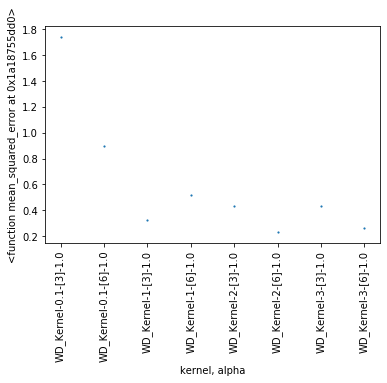

optimal kernel:  WD_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.05681314714746539
Test:  0.12678598130211877


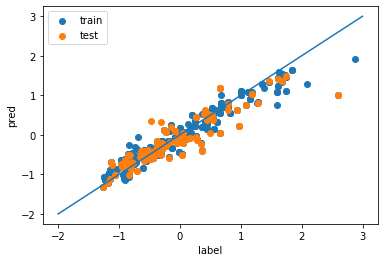

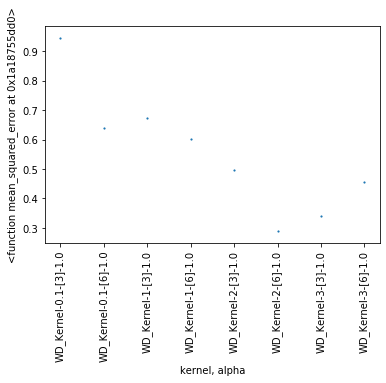

optimal kernel:  WD_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.057522385567922905
Test:  0.1819477700426074


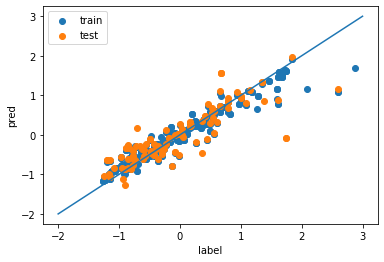

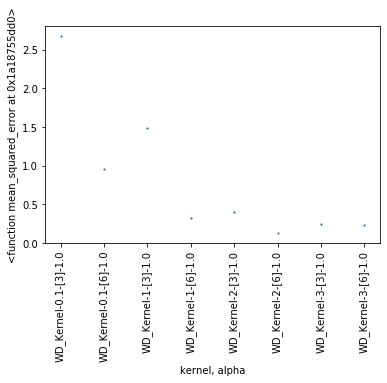

optimal kernel:  WD_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.05813420469096641
Test:  0.16414181655980942


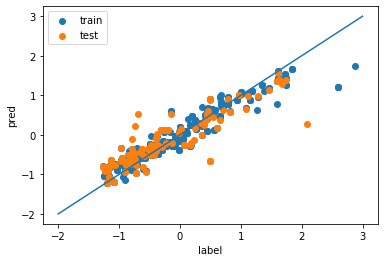

Cross-validation Test mean:  0.16334932813879266
Cross-validation Test std:  0.04354999383037577


In [11]:
optimal_para, test_scores = cross_val(df_samples, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

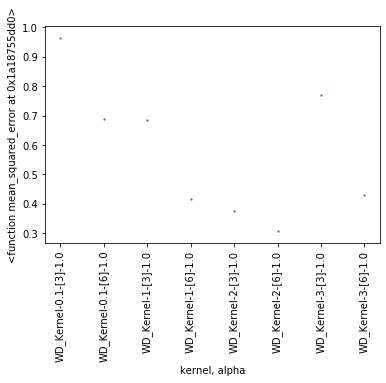

optimal kernel:  WD_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.05975032346937684
Test:  0.09035720535849887


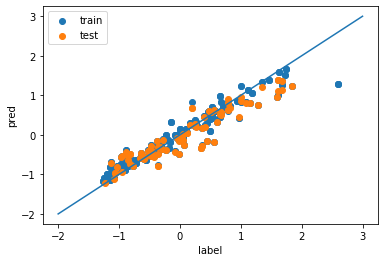

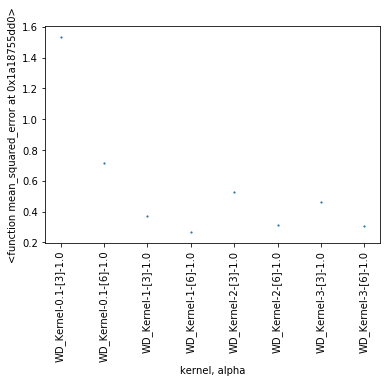

optimal kernel:  WD_Kernel , optimal alpha:  1 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.02959729913157787
Test:  0.8482630526275065


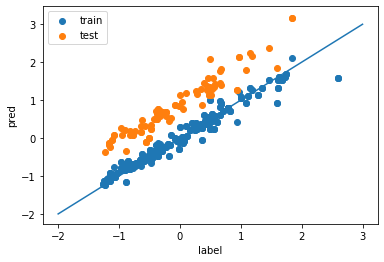

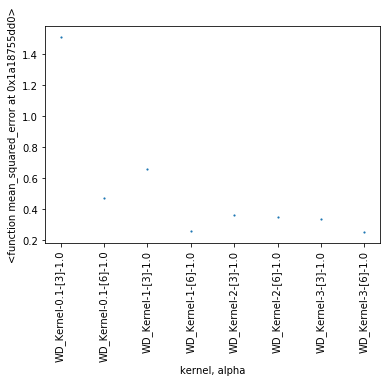

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.062479550205858624
Test:  0.2772779743342459


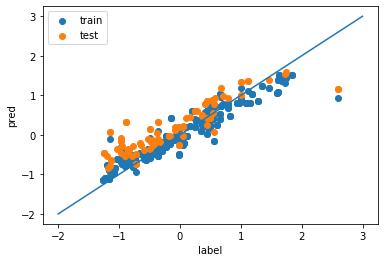

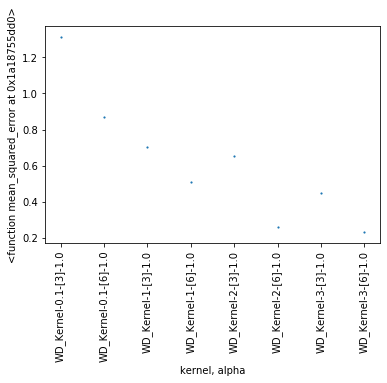

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.07624697021516252
Test:  0.15875697018335272


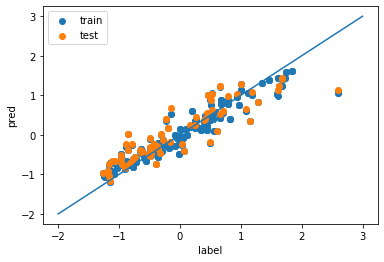

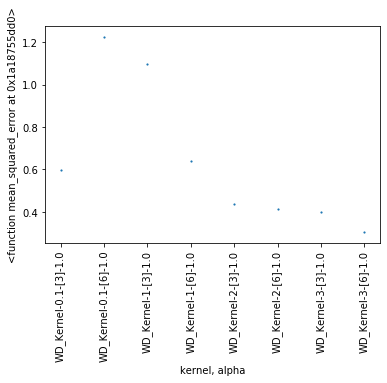

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.07650931572805966
Test:  0.10974029341305441


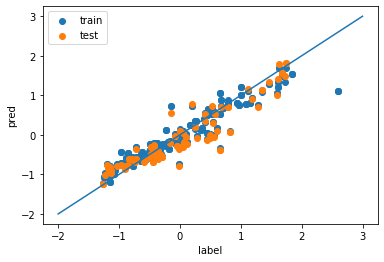

Cross-validation Test mean:  0.29687909918333166
Cross-validation Test std:  0.28325197827541654


In [12]:
optimal_para, test_scores = cross_val(df_samples_frr, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting samples case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  0.1 , 
- optiaml l list:  [2, 3, 4, 5, 6]
    
As we expected, when splitting in terms of samples, we have a smaller test error and smaller test error variance as well compared splitting in terms of sequences.

## Normalise replicates?

normalise each replicates to have same derivatives i.e. heteroscedastic noises are learned 

In [13]:
num_data = df.shape[0]
sorted_df = df.sort_values(['AVERAGE'])

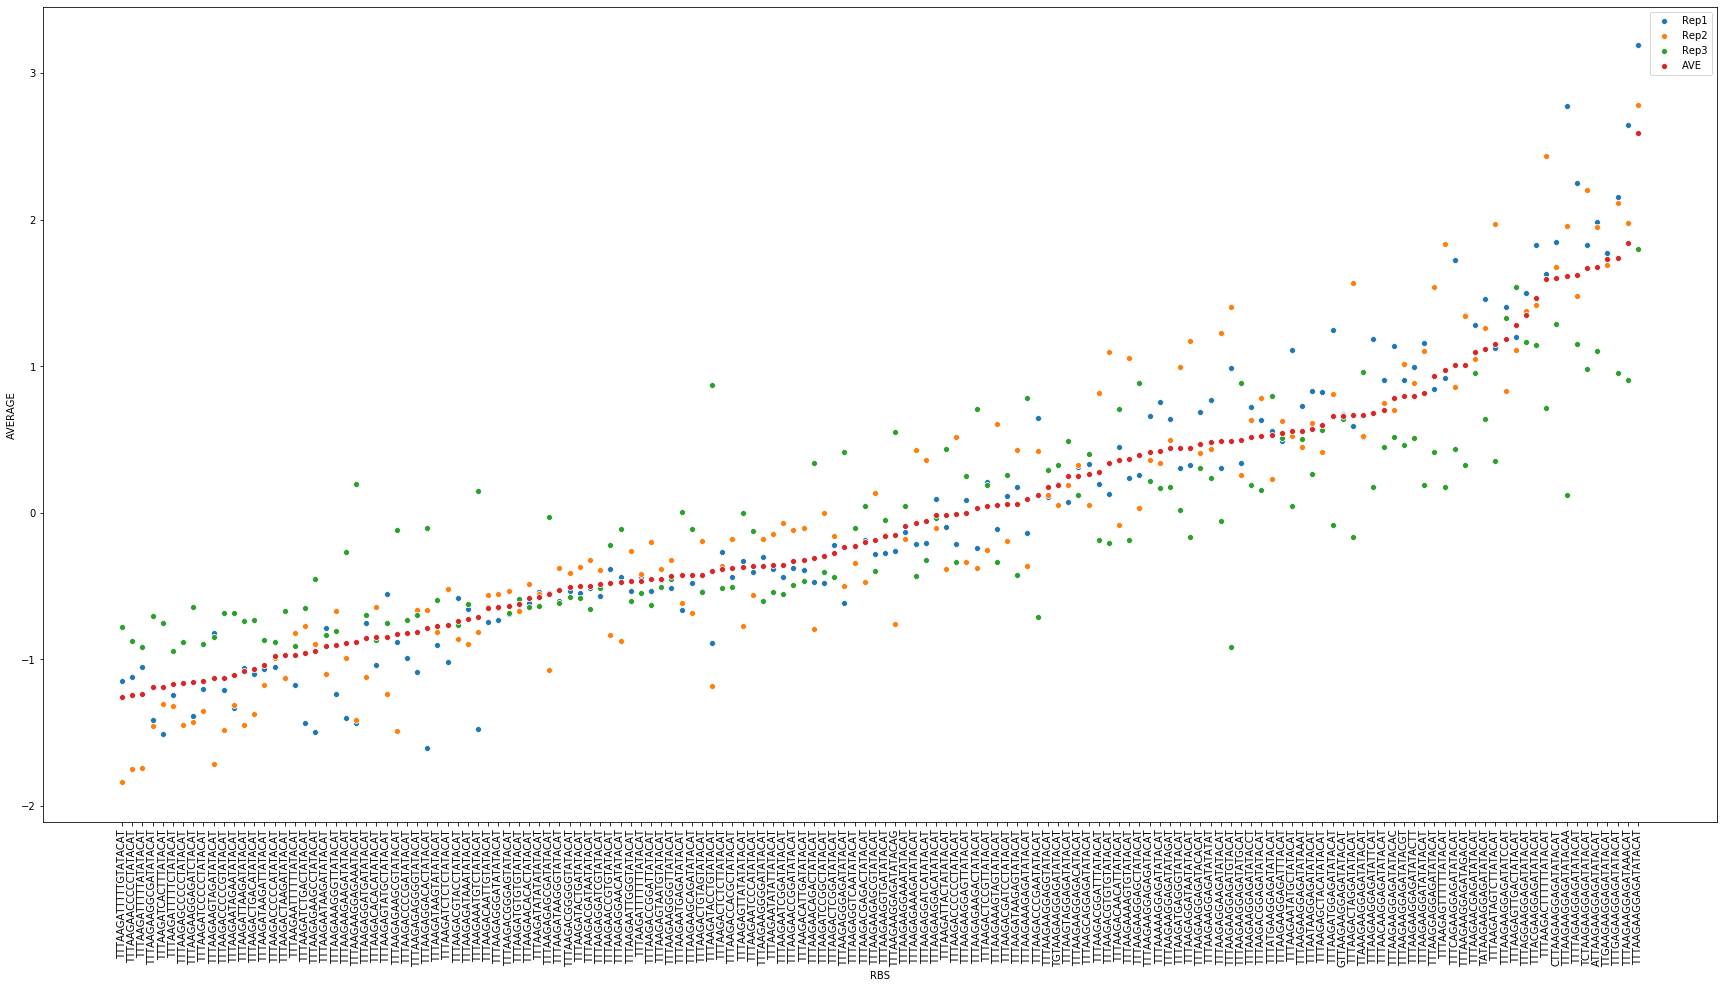

In [14]:
plt.figure(figsize = (30,15))
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep1'], label = 'Rep1')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep2'], label = 'Rep2')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep3'], label = 'Rep3')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['AVERAGE'], label = 'AVE')
labels = sorted_df['RBS']
ax.set_xticklabels(labels, rotation = 90)
plt.show()

[ 0.02173667 -1.61938168]
[ 0.02146547 -1.59917732]
[ 0.01188477 -0.94332214]
[ 0.01844038 -1.39109994]


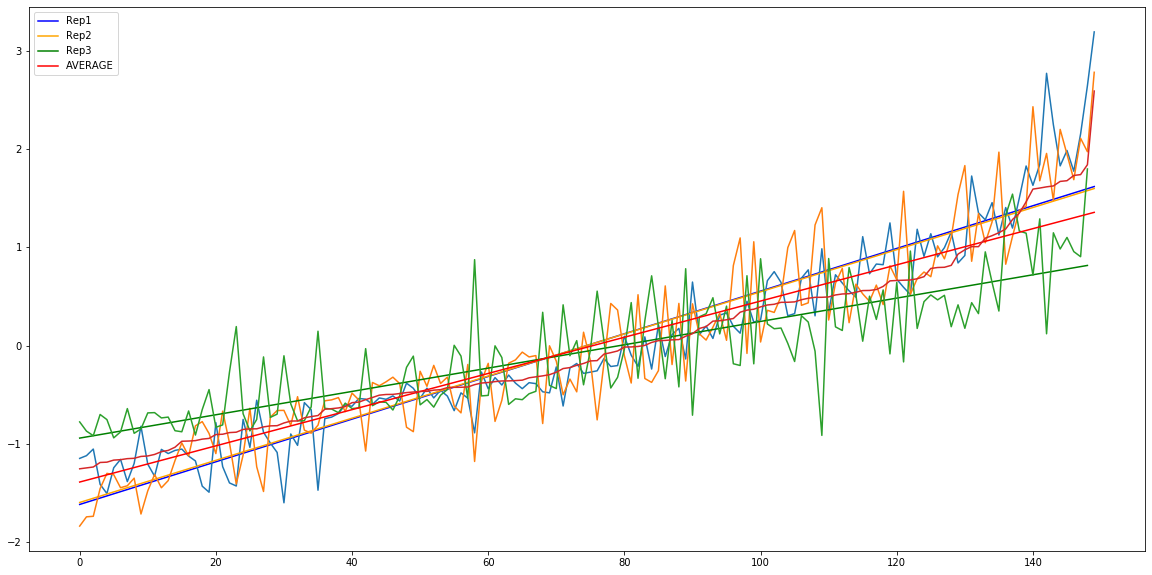

In [15]:
# fit curve

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

plt.figure(figsize = (20,10))

color_list = ['blue', 'orange', 'green', 'red']
popt_dict = {}

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ydata = np.asarray(sorted_df[rep].dropna())
    xdata = range(len(ydata))
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    popt_dict[rep] = popt
    plt.plot(xdata, func(xdata, *popt), label = rep, color = color_list[i])
    plt.plot(xdata, ydata)
    plt.legend()

In [16]:
# normalise?

popt_dict

{'Rep1': array([ 0.02173667, -1.61938168]),
 'Rep2': array([ 0.02146547, -1.59917732]),
 'Rep3': array([ 0.01188477, -0.94332214]),
 'AVERAGE': array([ 0.01844038, -1.39109994])}

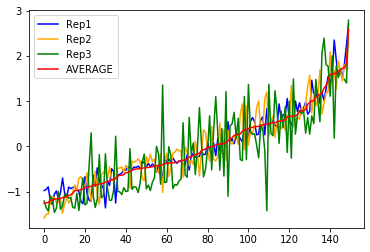

In [17]:
df_normalised = sorted_df

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ratio = popt_dict[rep][0]/popt_dict['AVERAGE'][0]
    df_normalised[rep] = sorted_df[rep]/ratio
    normalised_rep = np.asarray(df_normalised[rep])
    
    xdata = range(len(normalised_rep))
    
    plt.plot(xdata, normalised_rep, label = rep, color = color_list[i])
    plt.legend()

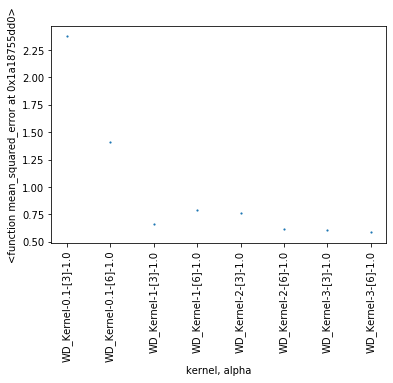

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.06114020359215206
Test:  0.5673095366002427


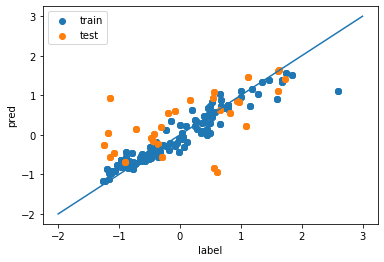

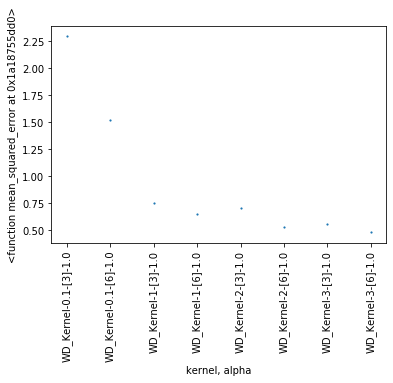

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.058580048670470536
Test:  0.5771198806590713


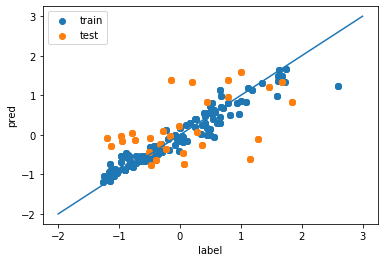

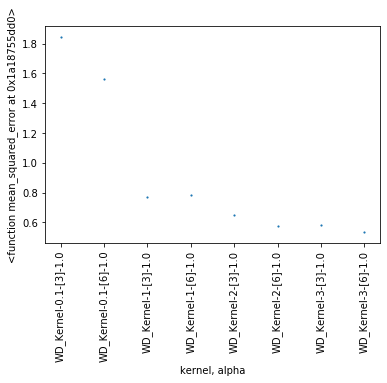

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.044046509736850085
Test:  0.6170695554345358


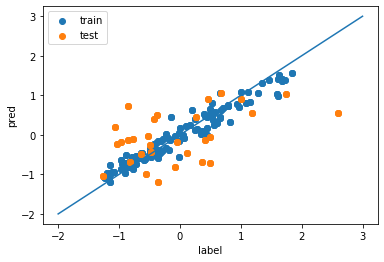

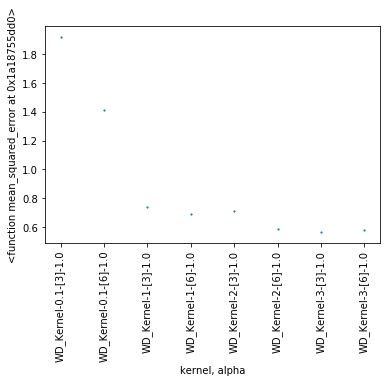

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [3] , optimal b:  1.0
WD_Kernel
1
Train:  0.12618451253781335
Test:  0.6261729511189024


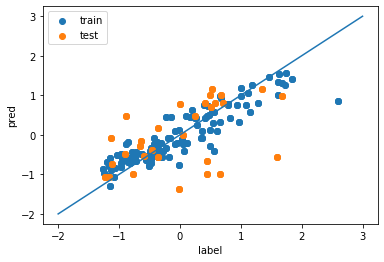

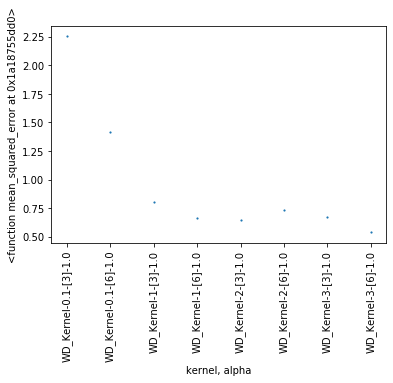

optimal kernel:  WD_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
WD_Kernel
1
Train:  0.06285536047780414
Test:  0.4797387153337397


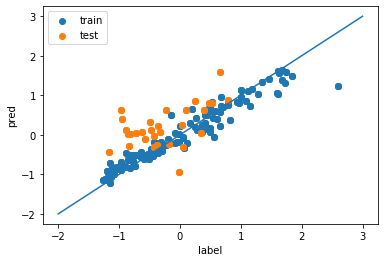

Cross-validation Test mean:  0.5734821278292983
Cross-validation Test std:  0.05199105349696636


In [18]:
optimal_para, test_scores = cross_val(df_normalised, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                     l_lists, b_list, weight_flag, padding_flag, gap_flag)

Unfortunately, from the test error mean and std, normalise replicates seem to have little effect on the perforamcne. 

## Summary

To summarise, for the second round design, we choose to use all first round results (NO baseline data), with 
- Spectrum kennel
- alpha = 2
- lmer, l = [2,3,4,5,6]
- with replicates normalisation
- Sample mean as true label
- normalised kernel
- (TODO) features: no gap, np padding, no weight?